In [1]:
# https://github.com/pytorch/examples/blob/master/mnist/main.py
from __future__ import print_function
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import PIL
from random import shuffle
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
import pickle

In [3]:
with open('dataconv.pt', 'rb') as f:
    data = pickle.load(f)
    
with open('labels.pt', 'rb') as f:
    labels = pickle.load(f)

In [4]:
class AffonsoNet(nn.Module):

    def __init__(self,dropout = 0.5):
        super(AffonsoNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, kernel_size=10)
        self.conv2 = nn.Conv2d(20, 25, kernel_size=10)
        self.fc1 = nn.Linear(14875,4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 4)
        self.mp = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        in_size = x.size(0)
        x = self.mp(x)
        x = self.mp(x)
        x = self.dropout(torch.relu(self.conv1(x)))
        x = self.mp(x)
        x = self.dropout(torch.relu(self.conv2(x)))
        x = self.mp(x)
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return torch.log_softmax(x,1)


In [ ]:
class AutoUXDataset(Dataset):
    def __init__(self, data, labels,isTrain=True):
        self.data = data
        self.labels = labels
        self.isTrain = isTrain
        self.setTest(0)

    def __len__(self):
        if self.isTrain:
            return len(self.trainX)
        else:
            return len(self.testX)

    def setTest(self,testI):
        d = []
        l = []
        for i in range(5):
            if i != testI:
                d = d + data[i];
                l = l + labels[i]
            else:
                self.testX = torch.from_numpy(np.asarray(data[i],dtype=np.uint8)).type('torch.FloatTensor')
                self.testY = torch.from_numpy(np.asarray(labels[i],dtype=np.uint8)).type('torch.LongTensor')
                
        self.trainX = torch.from_numpy(np.asarray(d,dtype=np.uint8)).type('torch.FloatTensor')
        self.trainY = torch.from_numpy(np.asarray(l,dtype=np.uint8)).type('torch.LongTensor')
    
    def __getitem__(self, idx):
        if self.isTrain:
            return {"img" : self.trainX[idx], "label": self.trainY[idx]}
        else:
            return {"img" : self.testX[idx], "label": self.testY[idx]}

In [5]:
def train_batch(model,crit,opt,x, y):
    opt.zero_grad()
    y_pred = model(x)
    loss = crit(y_pred, y)
    loss.backward()
    opt.step() 
    return loss.item(),torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

def train(model,crit,opt,dataload,disable=False):
    # Training loop
    dloss, dacc = 0,0
    for s in tqdm(dataload,disable=disable):
        x, y = s.values()
        x = x.cuda()
        y = y.cuda()
        lo, acc = train_batch(model,crit,opt,x,y)
        dloss += lo
        dacc += acc
    dloss /= len(dataload)
    dacc /= len(dataload)
    return dloss,dacc

def test_batch(model,crit,x, y):
    y_pred = model(x)
    loss = crit(y_pred, y)
    return loss.item(),torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

def test(model,crit,dataload,disable=False):
    # Training loop
    dloss, dacc = 0,0
    with torch.no_grad():
        for s in tqdm(dataload,disable=disable):
            x, y = s.values()
            x = x.cuda()
            y = y.cuda()
            lo, acc = test_batch(model,crit,x,y)
            dloss += lo
            dacc += acc
    dloss /= len(dataload)
    dacc /= len(dataload)
    return dloss,dacc

In [ ]:
avedloss, avedacc, avevloss, avevacc = 0,0,0,0
my_data = AutoUXDataset(data,labels,True)
my_test = AutoUXDataset(data,labels,False)

batch_size = 128
disable = False
epochs = 50
dropout = 0.5
weight_decay = 0.5

for i in range(5):
    model = AffonsoNet(dropout=dropout).cuda()
    optimizer = optim.Adam(model.parameters(), lr=3e-4,weight_decay=weight_decay)
    #amp_handle.wrap_optimizer(optimizer)
    criterion = nn.CrossEntropyLoss()
    #amp_handle = amp.init()
    dlosscurve = []
    dacccurve = []
    vlosscurve = []
    vacccurve = []
    print("Fold %d" % (i + 1))
    my_data.setTest(i)
    my_test.setTest(i)
    
    my_loader = DataLoader(my_data, batch_size=batch_size,
                            shuffle=True)
    my_test_loader = DataLoader(my_test, batch_size=batch_size,
                            shuffle=True)
    for j in range(epochs):
        dloss, dacc = train(model,criterion,optimizer,my_loader,disable)
        vloss, vacc = test(model,criterion,my_test_loader,disable)
        dlosscurve.append(dloss)
        dacccurve.append(dacc)
        vlosscurve.append(vloss)
        vacccurve.append(vacc)
        if j % 1 == 0:
            print("Epoch Train Loss: {:.6f}  Epoch Train Accuracy: {:.6f}  Epoch Test Loss: {:.6f}  Epoch Test Accuracy: {:.6f}".format(dloss,dacc * 100,vloss,vacc * 100))
    df = pd.DataFrame(data={"train_loss": dlosscurve, "val_loss": vlosscurve})
    df.plot.line()
    avedloss += dloss
    avedacc += dacc
    avevloss += vloss
    avevacc += vacc
avedloss /= 5
avedacc /= 5
avevloss /= 5
avevacc /= 5
print("Average Train Loss: {:.6f}\nAverage Train Accuracy: {:.6f}\nAverage Test Loss: {:.6f}\nAverage Test Accuracy: {:.6f}\n".format(avedloss,avedacc,avevloss,avevacc))

In [6]:
class AutoUXFullDataset(Dataset):
    def __init__(self, data, labels):
        super(AutoUXFullDataset,self).__init__()
        self.data = data
        self.labels = labels
        d = []
        l = []
        for i in range(5):
            d = d + data[i];
            l = l + labels[i]
        self.trainX = torch.from_numpy(np.asarray(d,dtype=np.uint8)).type('torch.FloatTensor')
        self.trainY = torch.from_numpy(np.asarray(l,dtype=np.uint8)).type('torch.LongTensor')

    def __len__(self):
        return len(self.trainX)
    
    def __getitem__(self, idx):
        return {"img" : self.trainX[idx], "label": self.trainY[idx]}

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  5.20it/s]


Epoch Train Loss: 1.163997  Epoch Train Accuracy: 48.333333


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.68it/s]


Epoch Train Loss: 0.738719  Epoch Train Accuracy: 50.997024


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.97it/s]


Epoch Train Loss: 0.696240  Epoch Train Accuracy: 53.080357


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.95it/s]


Epoch Train Loss: 0.683132  Epoch Train Accuracy: 56.780754


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.76it/s]


Epoch Train Loss: 0.716521  Epoch Train Accuracy: 56.840278


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.95it/s]


Epoch Train Loss: 0.660571  Epoch Train Accuracy: 60.783730


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.90it/s]


Epoch Train Loss: 0.635345  Epoch Train Accuracy: 64.131944


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.91it/s]


Epoch Train Loss: 0.648871  Epoch Train Accuracy: 63.551587


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.91it/s]


Epoch Train Loss: 0.635907  Epoch Train Accuracy: 65.694444


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.85it/s]


Epoch Train Loss: 0.623970  Epoch Train Accuracy: 66.309524


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.81it/s]


Epoch Train Loss: 0.622401  Epoch Train Accuracy: 65.749008


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.61it/s]


Epoch Train Loss: 0.628948  Epoch Train Accuracy: 64.503968


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.93it/s]


Epoch Train Loss: 0.627542  Epoch Train Accuracy: 65.634921


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.76it/s]


Epoch Train Loss: 0.624169  Epoch Train Accuracy: 67.212302


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.87it/s]


Epoch Train Loss: 0.603675  Epoch Train Accuracy: 67.564484


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.71it/s]


Epoch Train Loss: 0.616636  Epoch Train Accuracy: 65.853175


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.93it/s]


Epoch Train Loss: 0.639109  Epoch Train Accuracy: 64.216270


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.86it/s]


Epoch Train Loss: 0.608230  Epoch Train Accuracy: 65.223214


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.95it/s]


Epoch Train Loss: 0.605472  Epoch Train Accuracy: 68.918651


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.96it/s]


Epoch Train Loss: 0.598379  Epoch Train Accuracy: 68.040675


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.86it/s]


Epoch Train Loss: 0.611824  Epoch Train Accuracy: 67.311508


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.70it/s]


Epoch Train Loss: 0.592250  Epoch Train Accuracy: 68.516865


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.88it/s]


Epoch Train Loss: 0.579804  Epoch Train Accuracy: 70.545635


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.79it/s]


Epoch Train Loss: 0.594841  Epoch Train Accuracy: 69.697421


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.83it/s]


Epoch Train Loss: 0.561700  Epoch Train Accuracy: 73.839286


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.00it/s]


Epoch Train Loss: 0.577295  Epoch Train Accuracy: 69.563492


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.96it/s]


Epoch Train Loss: 0.579578  Epoch Train Accuracy: 69.335317


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.73it/s]


Epoch Train Loss: 0.567405  Epoch Train Accuracy: 69.181548


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.79it/s]


Epoch Train Loss: 0.550795  Epoch Train Accuracy: 70.897817


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.68it/s]


Epoch Train Loss: 0.583761  Epoch Train Accuracy: 70.277778


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.67it/s]


Epoch Train Loss: 0.539522  Epoch Train Accuracy: 71.532738


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.94it/s]


Epoch Train Loss: 0.535391  Epoch Train Accuracy: 72.668651


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.87it/s]


Epoch Train Loss: 0.528750  Epoch Train Accuracy: 74.722222


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.99it/s]


Epoch Train Loss: 0.519231  Epoch Train Accuracy: 75.069444


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.97it/s]


Epoch Train Loss: 0.514973  Epoch Train Accuracy: 74.136905


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.04it/s]


Epoch Train Loss: 0.510761  Epoch Train Accuracy: 74.717262


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.73it/s]


Epoch Train Loss: 0.504256  Epoch Train Accuracy: 74.424603


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.01it/s]


Epoch Train Loss: 0.509079  Epoch Train Accuracy: 75.089286


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.89it/s]


Epoch Train Loss: 0.506434  Epoch Train Accuracy: 75.496032


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.87it/s]


Epoch Train Loss: 0.506275  Epoch Train Accuracy: 75.342262


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.93it/s]


Epoch Train Loss: 0.459352  Epoch Train Accuracy: 79.246032


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.79it/s]


Epoch Train Loss: 0.476945  Epoch Train Accuracy: 77.574405


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.71it/s]


Epoch Train Loss: 0.466872  Epoch Train Accuracy: 77.534722


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.92it/s]


Epoch Train Loss: 0.456883  Epoch Train Accuracy: 79.047619


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.90it/s]


Epoch Train Loss: 0.471258  Epoch Train Accuracy: 79.255952


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.91it/s]


Epoch Train Loss: 0.437397  Epoch Train Accuracy: 78.576389


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.81it/s]


Epoch Train Loss: 0.454762  Epoch Train Accuracy: 78.417659


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.85it/s]


Epoch Train Loss: 0.461504  Epoch Train Accuracy: 78.363095


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.84it/s]


Epoch Train Loss: 0.445803  Epoch Train Accuracy: 79.454365


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.87it/s]


Epoch Train Loss: 0.439925  Epoch Train Accuracy: 79.811508
Average Train Loss: 0.439925
Average Train Accuracy: 0.798115


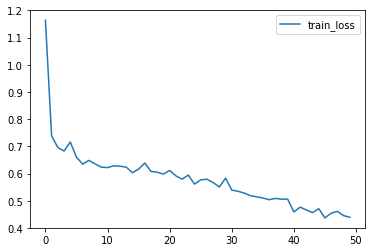

In [7]:
avedloss, avedacc = 0,0
my_data = AutoUXFullDataset(data,labels)

batch_size = 64
disable = False
epochs = 50
every_other = 1

model = AffonsoNet(0.5).cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-4,weight_decay=0.1)
#amp_handle.wrap_optimizer(optimizer)
criterion = nn.CrossEntropyLoss()
#amp_handle = amp.init()
dlosscurve = []
dacccurve = []

my_loader = DataLoader(my_data, batch_size=batch_size,
                        shuffle=True)
for j in range(epochs):
    dloss, dacc = train(model,criterion,optimizer,my_loader,disable)
    dlosscurve.append(dloss)
    dacccurve.append(dacc)
    if j % every_other == 0:
        print("Epoch Train Loss: {:.6f}  Epoch Train Accuracy: {:.6f}".format(dloss,dacc * 100))
df = pd.DataFrame(data={"train_loss": dlosscurve})
df.plot.line()
avedloss += dloss
avedacc += dacc
print("Average Train Loss: {:.6f}\nAverage Train Accuracy: {:.6f}".format(avedloss,avedacc))

In [8]:
my_loader = DataLoader(my_data, batch_size=batch_size,
                        shuffle=False)
answers = np.array([])
preds = np.array([])
with torch.no_grad():
    for s in tqdm(my_loader,disable=disable):
        x, y = s.values()
        x = x.cuda()
        y = y.cuda()
        y_pred = model(x).cpu()
        answers = np.append(answers,y_pred[:,1])
        preds = np.append(preds,torch.max(y_pred,1)[1])
answers = np.exp(answers)
print(answers)
print(preds)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.53it/s]


[6.60320154e-01 8.09366637e-01 8.91759168e-01 3.68900828e-01
 9.62173138e-01 3.56582149e-01 7.97440795e-01 8.88447523e-01
 6.77808159e-01 5.30904318e-01 6.18149181e-01 9.57050102e-01
 9.23402576e-01 8.17705967e-01 7.95400141e-01 1.49685740e-01
 3.85959794e-01 7.91364294e-01 2.17776072e-01 1.38559070e-01
 5.79960070e-02 8.03906006e-01 2.14680735e-01 2.74122085e-01
 6.87933538e-02 8.08756290e-02 1.45913361e-02 4.05803778e-02
 1.28267511e-01 4.58231940e-02 7.19269766e-01 3.70082868e-01
 2.90230011e-01 5.09318651e-01 8.19561128e-01 6.91764451e-01
 5.96451843e-01 5.59982047e-01 7.60997708e-01 9.01559584e-02
 7.64012052e-01 2.03472949e-01 4.29454841e-01 9.51248747e-01
 8.65049121e-01 3.10848707e-02 6.97638952e-02 1.11163598e-01
 8.27841438e-02 5.83365606e-02 1.10232759e-03 1.43823547e-01
 3.23343285e-01 3.41526215e-02 2.62582003e-02 2.96616384e-02
 2.83370191e-02 2.34646621e-02 2.00545564e-02 1.34699707e-02
 4.93995415e-01 8.70190529e-01 8.47902631e-01 7.89770834e-01
 2.14297097e-01 9.674421

In [9]:
with open('AffonsoNetoutprobs.pt', 'wb') as f:
    pickle.dump(answers, f)

Confusion matrix, without normalization
[[207 258]
 [203 270]]
Normalized confusion matrix
[[0.45 0.55]
 [0.43 0.57]]


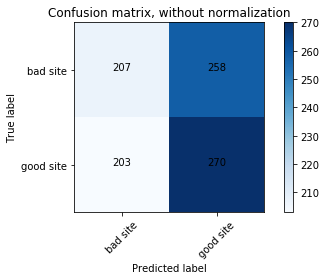

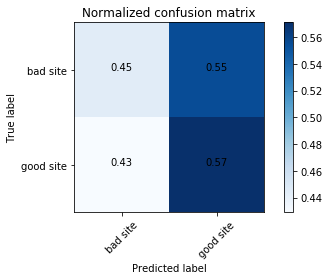

Accuracy: 0.5085


In [7]:
from sklearn.metrics import *
import itertools
import pickle
with open('AffonsoNetout.pt', 'rb') as f:
    y_pred = pickle.load(f)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


y_test = np.array([])

for x in labels:
    y_test = np.append(y_test,x)

class_names = ["bad site","good site"]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
print("Accuracy: {:.4f}".format(np.mean(y_test==y_pred)))